In [ ]:
# default_exp fontsampler
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# aifont.fontsampler

> Utilities to create images from Google Fonts. Code mostly by https://erraticgenerator.com/blog/use-google-fonts-for-machine-learning-part1/

In [ ]:
#hide
from nbdev.showdoc import *

## Rendering Font Images

> Selecting Google Fonts and rendering font images.

In [ ]:
#export
import glob
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import random
import re
from typing import Union

In [ ]:
class FontSampler:
    """Sample Google Fonts and render as images. `df` or `df_path` should point to font annotations
       (see `create_font_annotations`), `font_path` to the root folder of the ofl fonts. Control
       font selection with `variants`, `subsets` and `category`, which can be either strings or 
       regexs."""
    def __init__(self, df: pd.DataFrame = None, df_path: str = "data/google-fonts-annotation.csv", 
        font_path: str = "data/fonts", variants: list[str] = None, subsets: list[str] = None, 
        category: str = None, image_width: int = 256, image_height: int = 256):
        self.df = pd.read_csv(df_path) if df is None else df
        self.font_path = font_path
        self.variants = variants
        self.subsets = subsets
        self.category = category
        self.image_width = image_width
        self.image_height = image_height
        self.font_index = -1
        self.paths = self.filter_fonts_get_paths()

    @property
    def num_fonts(self):
        return len(self.paths)

    def filter_fonts_get_paths(self, variants: list[str] = None, subsets: list[str] = None, 
        category: str = None) -> list[str]:
        """Filter the fonts list by the criteria and return a list of file paths."""

        df = self.df
        font_path = self.font_path
        if variants is None:
            variants = self.variants
        if subsets is None:
            subsets = self.subsets
        if category is None:
            category = self.category

        # exceptions
        if variants is None or variants == [''] or variants == '': 
            variants = ['_']
        if subsets is None or subsets == [''] or subsets == '': 
            subsets = ['_']
        if category is None:
            category = ''

        # apply filters
        regex_filters = variants + subsets + ['_' + category]
        df_new = pd.concat([df.filter(regex=re.compile(regex, re.IGNORECASE), axis=1).sum(axis=1).astype(bool) for regex in regex_filters], axis=1)
        mask = df_new.all(axis=1)
        filtered_fontnames = list(df.loc[mask].family)
        
        # construct file paths
        paths = []
        for fontname in filtered_fontnames:
            if variants == ['_']: # select all variants
                sel = glob.glob(f'{font_path}/{fontname.lower()}/**/*.ttf', recursive=True)
                paths.extend(sel)
            else:
                for variant in variants:
                    sel = glob.glob(f'{font_path}/{fontname.lower()}/**/{fontname}-{variant}.ttf', recursive=True) 
                    for path in sel:
                        paths.append(path)

        if len(paths) == 0:
            raise Exception("No matching fonts found!")
        # print(f'Found {len(paths)} font files.')

        # Reset index
        self.font_index = -1

        random.shuffle(paths)
        return paths

    def render_text(self, text: str, text_size: int = None, x: int = None, y: int = None, 
        font_index: int = None, image_width: int = None, image_height: int = None, 
        as_normalised_array = False) -> Union[np.ndarray, Image.Image, None]:
        """Render the given text as black on white and return either as a normalised 
           numpy array of (alpha) values or a PIL Image. If called without font_index, 
           will iterate over all paths and return None once the end is reached."""

        paths = self.paths
        if font_index is None:
            if self.font_index >= len(paths):
                self.font_index = -1
                return None
            self.font_index += 1
            font_index = self.font_index

        # sample text and font
        if text_size is None:
            text_size = round(self.image_height * .8)
        if image_width is None:
            image_width = self.image_width
        if image_height is None:
            image_height = self.image_height
        
        if x is None:
            x = image_width  * .5
        if y is None:
            # Try to find a nice y location for the text keeping in mind that descenders
            # will reach below this point and might thus fall offcanvas
            y = text_size + max(0, (image_height - text_size * 1.5) / 2)
        font = ImageFont.truetype(paths[font_index % len(paths)], text_size)

        # get text info (not being used but may be useful)
        # text_width, text_height = font.getsize(text)
        # left, top, right, bottom = font.getbbox(text)
        # print(left, top, right, bottom)

        # create a blank canvas
        canvas = Image.new('L', (image_width, image_height), 'white')

        # draw the text onto the text canvas
        draw = ImageDraw.Draw(canvas)
        draw.text((x, y), text, 'black', font, anchor='ms')

        # Convert to normalised list if needed
        if as_normalised_array:
            return np.reshape([(255 - x) / 255. for x in list(canvas.getdata())],
                              (image_height, image_width))
        return canvas


Render a letter as a grayscale image.

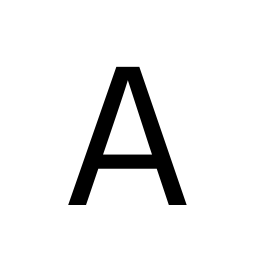

In [ ]:
fs = FontSampler(category="sans-serif")
img = fs.render_text('A'); img

Or as a numpy matrix.

In [ ]:
np_img = fs.render_text('A', as_normalised_array=True, font_index=0)
print(f"Shape: {np_img.shape}")
print(np_img)

Shape: (256, 256)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


To use it with `diffvg`, use the values as the A-band of the RGBA tensors.

In [ ]:
import torch
import torch.nn.functional as F

wd_ht = torch.tensor(np_img, dtype=torch.float32)
wd_ht_a = torch.reshape(wd_ht, wd_ht.shape + tuple([1]))
wd_ht_rgba = F.pad(input=wd_ht_a, pad=(3, 0, 0, 0, 0, 0), mode='constant', value=0)
wd_ht.shape, wd_ht_a.shape, wd_ht_rgba.shape

(torch.Size([256, 256]), torch.Size([256, 256, 1]), torch.Size([256, 256, 4]))

## Getting Font Metadata

> Get font metadata from the Google Fonts API. Needed only once. You need an API key for this.

In [ ]:
#export 
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

In [ ]:
#export
def create_font_annotations(data_path: str = "data/webfonts.json", api_key: str = None, 
    save_path = "data/google-fonts-annotation.csv") -> pd.DataFrame:
    """Get Google Fonts metadata either from the API using `api_key` or from
       a local file at `data_path` and save the data as csv in `save_path`.
       Also returns the data frame."""

    assert api_key is not None or data_path is not None

    if data_path is not None:
        # Use JSON already downloaded
        df = pd.read_json(data_path)
    else:
        # Download json data once
        url = f"https://www.googleapis.com/webfonts/v1/webfonts?key={api_key}"
        df = pd.read_json(url, orient='')

    # flatten the JSON hierarchy (easier to handle this way)
    df = pd.json_normalize(df['items'])

    # select only the columns we need
    cols = ['family', 'variants', 'subsets', 'category']
    df = df[cols]
    # df.head(5)

    # Remove any space from family string so that it matchs with file name convention.
    df.family = [name.replace(' ', '') for name in df.family]

    mlb = MultiLabelBinarizer()

    # one-hot encoding + prefix
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('variants')),
                            columns=[x for x in mlb.classes_],
                            index=df.index))
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('subsets')),
                            columns=['subsets_' + x for x in mlb.classes_],
                            index=df.index))
    df = df.join(pd.get_dummies(df['category'], prefix="category")).drop(['category'], axis=1)

    col_names = {
        "100": "thin",
        "100italic": "thinitalic",
        "200": "extralight",
        "200italic": "extralightitalic",
        "300": "light",
        "300italic": "lightitalic",
        "400": "regular",
        "regular": "regular",
        "400italic": "italic",
        "italic": "italic",
        "500": "medium",
        "500italic": "mediumitalic",
        "600": "semibold",
        "600italic": "semibolditalic",
        "700": "bold",
        "700italic": "bolditalic",
        "800": "extrabold",
        "800italic": "extrabolditalic",
        "900": "black",
        "900italic": "blackitalic"
    }
    col_names = {k:f'variants_{v}' for k, v in col_names.items()}

    df = df.rename(col_names, axis='columns')

    # Export csv
    if not save_path.endswith(".csv"):
        save_path += ".csv"
    df.to_csv(save_path, index=False)

    return df


In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_fontsampler.ipynb.
Converted index.ipynb.
